In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import Holt
from sklearn.metrics import  mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Ex. 1: Grid search for double exponential smoothing (Holt’s method)

In [2]:
df = pd.read_csv('IBM.csv', index_col = 'Date', parse_dates = True)
df['Open']

Date
1962-02-01    6.978967
1962-02-02    7.068196
1962-02-05    7.112811
1962-02-06    7.023582
1962-02-07    7.036329
                ...   
1965-12-23    8.022626
1965-12-27    7.966858
1965-12-28    7.966858
1965-12-29    7.992750
1965-12-30    7.934990
Name: Open, Length: 985, dtype: float64

### Selecting part of data with good trend

<AxesSubplot:xlabel='Date'>

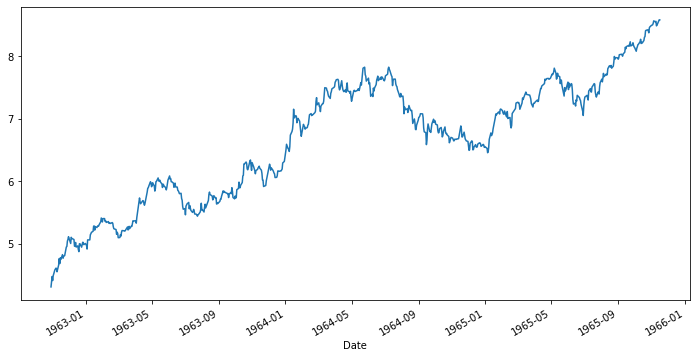

In [3]:
cut_l = int(0.19 * len(df))
cut_r = int(0.97 * len(df))
df = df['Open'].iloc[cut_l:cut_r]
df.plot(figsize = (12, 6))

### Setting frequency and filling in blanks

In [4]:
df = df.asfreq('b')
df = df.ffill(axis = 0)
df.head()

Date
1962-10-29    4.308477
1962-10-30    4.391332
1962-10-31    4.474187
1962-11-01    4.410453
1962-11-02    4.486934
Freq: B, Name: Open, dtype: float64

### Train and test split

In [5]:
ncut = int(0.8 * len(df))
train_data = df.iloc[:ncut]
test_data = df.iloc[ncut:]

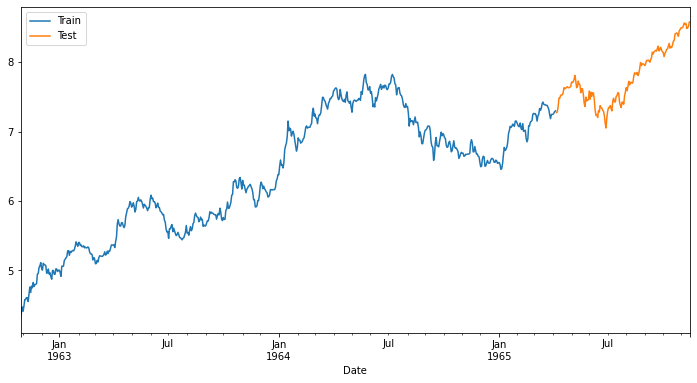

In [6]:
ax = train_data.plot(figsize = (12, 6))
test_data.plot(ax = ax)
plt.legend(['Train', 'Test'])

### Calculating manually

In [7]:
# parameters for best fit
min = 1
a_min = 0
b_min = 0

# main loop for changing smoothing parameters
for j in range (1, 99):
    a = j * 0.01
    #print(a)

    for k in range (1, 99):
        b = k * 0.01

        # arrays to keep level, trend and forecast values
        level = np.array([4.308477, ])
        trend = np.array([4.391332 - 4.308477, ])

        # first step
        l_0 = a * train_data.iloc[0] + (1 - a) * (level[0] + trend[0])
        t_0 = b * (l_0 - train_data.iloc[0]) + (1 - b) * trend[0]
        level = np.append(level, l_0)
        trend = np.append(trend, t_0)

        #loop for rest of data
        for i in range(1, ncut - 1):
            l_i = a * train_data.iloc[i] + (1 - a) * (level[i] + trend[i])
            t_i = b * (l_i - level[i]) + (1 - b) * trend[i]
            level = np.append(level, l_i)
            trend = np.append(trend, t_i)

        #convert numpy array to pandas dataframe
        level_df = pd.DataFrame(level, columns = ['Open'])
        level_df = level_df.set_index(train_data.index)

        #mean absolute error
        err = mean_absolute_percentage_error(train_data, level_df)

        if(err < min):
            min = err
            a_min = a
            b_min = b

#print results
print("Minimum error = " + str(100 * min) + "%\ta = " + str(a_min) + "\tb = " + str(b_min))

Minimum error = 0.7044346721700778%	a = 0.98	b = 0.01


### My forecast

In [8]:
# smoothing parameters
a = 0.98
b = 0.01

# arrays to keep level, trend and forecast values
level = np.array([4.308477, ])
trend = np.array([4.391332 - 4.308477, ])
fcast = np.array([])

# first step
l_0 = a * train_data.iloc[0] + (1 - a) * (level[0] + trend[0])
t_0 = b * (l_0 - train_data.iloc[0]) + (1 - b) * trend[0]
level = np.append(level, l_0)
trend = np.append(trend, t_0)

#loop for rest of data
for i in range(1, ncut - 1):
    l_i = a * train_data.iloc[i] + (1 - a) * (level[i] + trend[i])
    t_i = b * (l_i - level[i]) + (1 - b) * trend[i]
    level = np.append(level, l_i)
    trend = np.append(trend, t_i)

#forecasting
for i in range(1, len(test_data) + 1):
    fcast_i = level[ncut - 1] + i * trend[ncut - 1]
    fcast = np.append(fcast, fcast_i)

#convert to pandas dataframe
fcast = pd.DataFrame(fcast, columns = ['Open'])
fcast = fcast.set_index(test_data.index)

### Statsmodel Holt's forecast

In [9]:
fit_Holt = Holt(train_data, exponential = False).fit()
fcast_Holt = fit_Holt.forecast(len(test_data)).rename("Holt's model")
print(fit_Holt.params['smoothing_level'])
print(fit_Holt.params['smoothing_trend'])

0.9999999850988387
3.619108022372965e-17


### Comparing results on graph

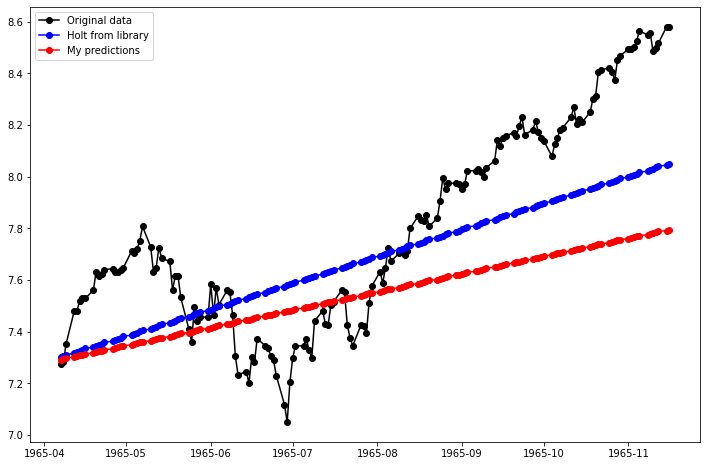

In [10]:
plt.figure(figsize = (12, 8))

#original data
plt.plot(test_data, marker = "o", color = "black")

#using Holt's from library
plt.plot(fcast_Holt, marker = "o", color = "blue")

#my predictions
plt.plot(fcast, marker = "o", color = "red")
plt.legend(['Original data', 'Holt from library', 'My predictions'])

# Ex. 2: Triple exponential smoothing (Holt-Winters’ method)

### Importing csv

In [11]:
df = pd.read_csv('USGas.csv', names = ['Data'])
index = pd.date_range(start = "2000-01", end = "2019-10", freq = "MS")
df = df.set_index(index)
df

,Data
2000-01-01,2510.5
2000-02-01,2330.7
2000-03-01,2050.6
2000-04-01,1783.3
2000-05-01,1632.9
...,...
2019-06-01,2115.2
2019-07-01,2407.5
2019-08-01,2437.2
2019-09-01,2215.6


<AxesSubplot:>

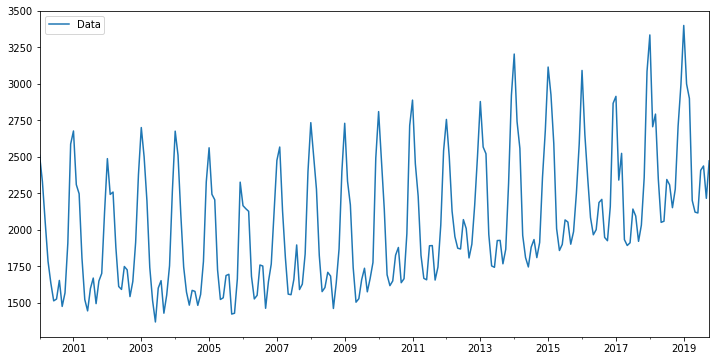

In [12]:
df.plot(figsize = (12, 6))

### Splitting into train and test to check out which combination of 'mul' and 'add' is the best

In [13]:
train_data = df.iloc[:-12]
test_data = df.iloc[-12:]

### Trend and seasonal both additive

In [14]:
fitHoltWinter = ExponentialSmoothing(train_data['Data'], trend = 'add', seasonal = 'add', seasonal_periods = 12).fit()
fcastHoltWinter = fitHoltWinter.forecast(len(test_data)).rename("Holt-Winter's predict")

<AxesSubplot:>

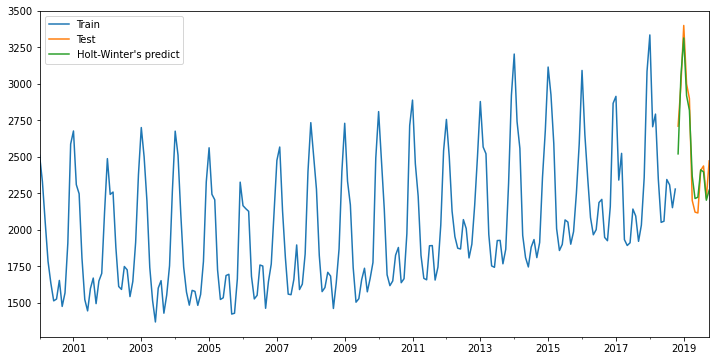

In [15]:
train_data['Data'].plot(figsize = (12, 6), legend = True, label = 'Train')
test_data['Data'].plot(legend = True, label = 'Test')
fcastHoltWinter.plot(legend = True, label = "Holt-Winter's predict")

In [16]:
# MSE
mean_squared_error(test_data, fcastHoltWinter)

12479.744296823448

### Additive trend and multiplicative seasonal component

In [17]:
fitHoltWinter = ExponentialSmoothing(train_data['Data'], trend = 'add', seasonal = 'mul', seasonal_periods = 12).fit()
fcastHoltWinter = fitHoltWinter.forecast(len(test_data)).rename("Holt-Winter's predict")

<AxesSubplot:>

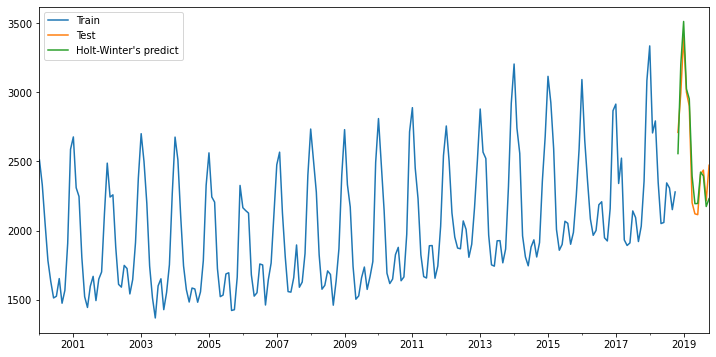

In [18]:
train_data['Data'].plot(figsize = (12, 6), legend = True, label = 'Train')
test_data['Data'].plot(legend = True, label = 'Test')
fcastHoltWinter.plot(legend = True, label = "Holt-Winter's predict")

In [19]:
# MSE
mean_squared_error(test_data, fcastHoltWinter)

16095.566429995903

### Multiplicative trend and additive seasonal component

In [20]:
fitHoltWinter = ExponentialSmoothing(train_data['Data'], trend = 'mul', seasonal = 'add', seasonal_periods = 12).fit()
fcastHoltWinter = fitHoltWinter.forecast(len(test_data)).rename("Holt-Winter's predict")

C:\Users\Rudy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


<AxesSubplot:>

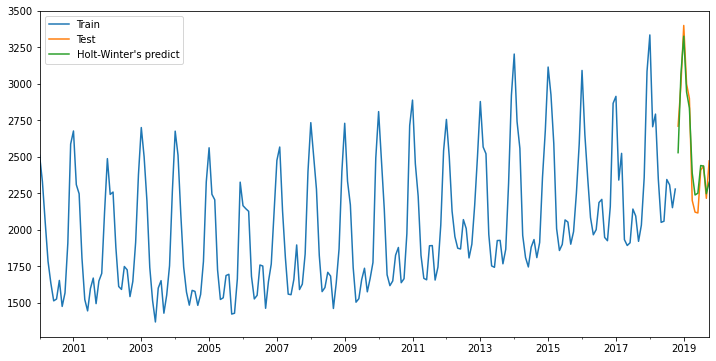

In [21]:
train_data['Data'].plot(figsize = (12, 6), legend = True, label = 'Train')
test_data['Data'].plot(legend = True, label = 'Test')
fcastHoltWinter.plot(legend = True, label = "Holt-Winter's predict")

In [22]:
# MSE
mean_squared_error(test_data, fcastHoltWinter)

11787.707820069258

### Trend and seasonal components are multiplicative

In [23]:
fitHoltWinter = ExponentialSmoothing(train_data['Data'], trend = 'mul', seasonal = 'mul', seasonal_periods = 12).fit()
fcastHoltWinter = fitHoltWinter.forecast(len(test_data)).rename("Holt-Winter's predict")

C:\Users\Rudy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


<AxesSubplot:>

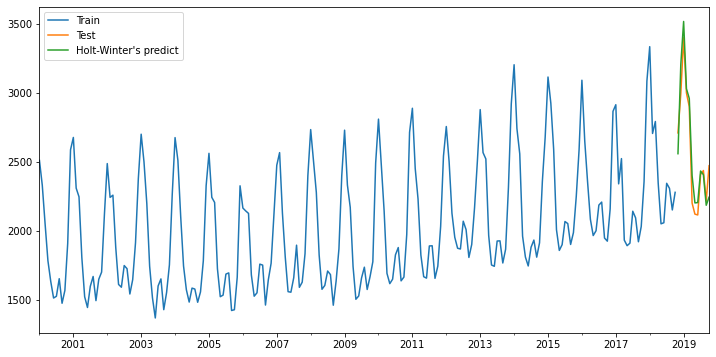

In [24]:
train_data['Data'].plot(figsize = (12, 6), legend = True, label = 'Train')
test_data['Data'].plot(legend = True, label = 'Test')
fcastHoltWinter.plot(legend = True, label = "Holt-Winter's predict")

In [25]:
# MSE
mean_squared_error(test_data, fcastHoltWinter)

16252.099092981241

### Best option seems to be multiplicative trend and additive seasonal component, using it for final forecast

In [26]:
fitHoltWinter = ExponentialSmoothing(df['Data'], trend = 'mul', seasonal = 'add', seasonal_periods = 12).fit()
fcastHoltWinter = fitHoltWinter.forecast(12).rename("Holt-Winter's predict")

C:\Users\Rudy\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


<AxesSubplot:>

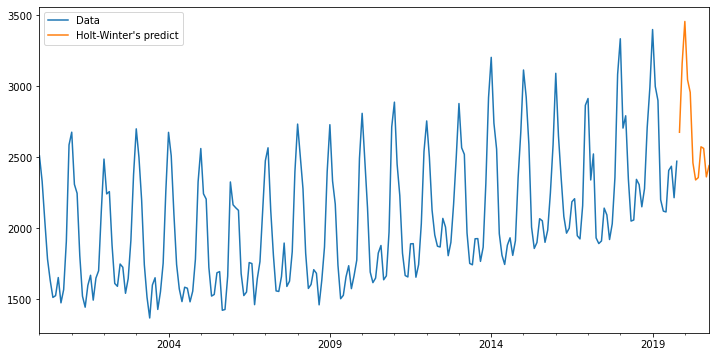

In [27]:
df['Data'].plot(figsize = (12, 6), legend = True, label = 'Data')
fcastHoltWinter.plot(legend = True, label = "Holt-Winter's predict")